In [7]:
import pandas as pd
from pandas import MultiIndex, Int16Dtype
import numpy as np
import cloudpickle
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from collections import defaultdict
from tqdm import tqdm
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor

pd.set_option('display.max_columns',None)

from warnings import filterwarnings
filterwarnings('ignore')


In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from utils import *

In [10]:
df=pd.read_csv("../../assets/assignment/df_train.csv.gz")
df['checkin_time'] = pd.to_datetime(df['checkin_time'])
df['year'] = df['checkin_time'].dt.year
df['month'] = df['checkin_time'].dt.month
df['DOY'] = df['checkin_time'].dt.day_of_year
# training_data=df.query("`event.id`=='583f013a-1e54-4906-87f7-2b625206f5f9' and `clean_categories.name`=='5k'")


In [11]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
unique_events = df['body.name'].unique()
print(len(unique_events))
training_event = np.random.choice(unique_events,size=101,replace=False)
tesing_event = [i for i in unique_events if not i in training_event]

#### by speed
train = df[df['body.name'].isin(training_event)]
train = train[~train['result.duration.chip'].isnull()]
test = df[df['body.name'].isin(tesing_event)]
test = test[~test['overall_ranking'].isnull()]

X_train,y_train, X_test, y_test = train[[i for i in train.columns if not i=='overall_ranking']], \
                                        train[['result.duration.chip']], \
                                        test[[i for i in train.columns if not i=='overall_ranking']], \
                                        test[['overall_ranking']]

y_train = np.array([i.seconds for i in pd.to_timedelta(y_train.iloc[:,0])])
len(X_train),len(y_train)

# ### by rank
# train = df[df['body.name'].isin(training_event)]
# train = train[~train['overall_ranking'].isnull()]
# test = df[df['body.name'].isin(tesing_event)]
# test = test[~test['overall_ranking'].isnull()]

# X_train,y_train, X_test, y_test = train[[i for i in train.columns if not i=='overall_ranking']], \
#                                         train[['overall_ranking']], \
#                                         test[[i for i in train.columns if not i=='overall_ranking']], \
#                                         test[['overall_ranking']]


# ######### train on all
# np.random.seed(42)

# train = df[~df['result.duration.chip'].isnull()]
# X_train = train[[i for i in train.columns if not i=='result.duration.chip']]
# y_train = train[['result.duration.chip']]
# y_train = np.array([i.seconds for i in pd.to_timedelta(y_train.iloc[:,0])])
           

In [12]:
y_train

array([6673, 5860, 8280, ..., 1874, 1820, 1999])

In [13]:
class my_Transformer():
    def __init__(self,event_cat_comb)-> None:
        self.event_cat_comb= event_cat_comb

    def fit(self, df, y = None):
        # self.profile = get_personal_profile(df)
        return self

    def transform(self, df, y=None):

        ##### part1
        #### age and bib
        part1 = df[['age','bib','price']].fillna(-1)
        part1['age'].loc[(part1['age']>100)|(part1['age']<1)] = -1
        
        ##### part2
        ## sex
        new_categories = transform_categories(df)
        new_distance = transform_distance(df)
        new_sex = transform_sex(df)
        new_travel_level = transform_travel_level(df)
        new_partici_info = transform_participants_info(df).fillna(-1)
        new_partici_info[(new_partici_info<0)|(new_partici_info>1e8)] = -1
        new_funding = transform_founding(df)
        new_time = transform_time(df)
        new_series_event_id = honest_transform_event(df,self.event_cat_comb)
        # new_profile = transform_profile(df,self.profile)

        variables_list = [part1, new_categories,  new_distance, new_sex, new_travel_level, new_partici_info, new_funding, new_time, new_series_event_id]
        variables_list = [i.reset_index(drop=True) for i in variables_list]
        X = pd.concat(variables_list, axis=1).fillna(-1)
        # X = pd.DataFrame(self.quantileTransformer.transform(X), columns=X.columns)
        # print(X.shape)
        return X

    

    


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold, GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb


m = my_Transformer(event_cat_comb=list(pd.unique(get_categories_combination(X_train))))
m.fit(X_train)
X_train_transformed = m.transform(X_train)
len(X_train_transformed)

# X_test_transformed = m.transform(X_test)

####
# imputer = IterativeImputer(DecisionTreeRegressor(random_state=42), 
#                 add_indicator=False, max_iter=2,
#                 random_state=42,missing_values=-1)

# imputer.fit(X_train_transformed)
# X_train_transformed[X_train_transformed.columns] = imputer.transform(X_train_transformed)


286342

In [15]:
new_categories = ['fun', 'run', 'walk', 'wheelchair', 'commitment',
       'bike', 'half marathon', 'marathon','fire fighter','quarter marathon',
       'mini-marathon','run swim run','10k', 'tri', 'dua','all'] + list(pd.unique(get_categories_combination(X_train)))

for i in new_categories:
    a = X_train_transformed[i].sum(axis=0)
    print(i,a)


fun 125
run 253144
walk 15467
wheelchair 12
commitment 714
bike 122
half marathon 10531
marathon 16016
fire fighter 4
quarter marathon 979
mini-marathon 1729
run swim run 235
10k 11478
tri 98
dua 271
all 286342
4d7f441a-4fbc-4a3e-b0d1-4e1b7f000001_15k 68741
4d7f441a-4fbc-4a3e-b0d1-4e1b7f000001_5k 89114
5a5b9a23-e89c-4100-bfa8-01e45206f5f9_marathon 374
5a5b9a23-e89c-4100-bfa8-01e45206f5f9_half marathon 1045
4d7f441a-4fbc-4a3e-b0d1-4e1b7f000001_15K 13514
4d7f441a-4fbc-4a3e-b0d1-4e1b7f000001_5K 19238
5af9d47d-56b4-4092-bf23-58085206f5f9_10k 2890
5af9d47d-56b4-4092-bf23-58085206f5f9_5k 5379
56d9b7b4-d73c-402f-ba50-1ae7c0a86526_10k 4860
56d9b7b4-d73c-402f-ba50-1ae7c0a86526_5k 2171
57a236ce-6c18-43fe-b8ac-13cd5206f5f9_5k 2307
4d7f441a-fc10-4bea-a491-4e1b7f000001_5 mile 2175
4d7f441a-5370-4fd0-bef6-4e1b7f000001_Half Marathon 1014
4d7f441a-5370-4fd0-bef6-4e1b7f000001_5K 266
5a317d2c-5c18-4312-92a6-245c5206f5f9_8k 261
58596d24-116c-41b4-8cae-5b565206f5f9_5k run 446
58596d24-116c-41b4-8cae-5b565

In [16]:


model_dict = {}
for cat in tqdm(new_categories):
    # model = XGBRegressor(random_state=42)
    # estimators = [
    #     ('xgb1',XGBRegressor(random_state=42)),
    #      ('xgb2',XGBRegressor(random_state=41)),
    #       ('xgb3',XGBRegressor(random_state=40)),
    # ]

    # model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
    
    
    new_X = X_train_transformed[X_train_transformed[cat]==1][['age', 'bib',  'price',  'fun', 'mile',
                        'run', 'walk', 'wheelchair',  'commitment',
                        'bike','half marathon','marathon', 'fire fighter',
                        'quarter marathon','mini-marathon','run swim run','10k',
                        'tri', 'dua','all',
                        'distance',  'Female',
                        'Male',  'Unspecified', 'travel_level',
                        'counts.participants.expected','counts.participants.registered', 'partici_quit_count',
                        'partici_quit_frac','fundraising.goal',
                        'month','doy', 'week_of_day', 'year', 'checkin_time']]
    new_Y = y_train[(X_train_transformed[cat]==1).values]
    if len(new_X)==0:
        continue

    model = xgb.XGBRegressor(random_state=42,n_jobs=1)
    # model = xgb.XGBRegressor(random_state=42)
    model.fit(new_X,new_Y)
    print(sorted(dict(zip(new_X.columns,model.feature_importances_)).items(), key=lambda x:x[1], reverse=True)[0:5])
    # except:
    #     continue
    model_dict[cat] = model





  0%|          | 0/201 [00:00<?, ?it/s]

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=775; total time=   0.3s
[CV] END ...................................n_estimators=775; total time=   0.3s
[CV] END ...................................n_est

  0%|          | 1/201 [00:03<13:15,  3.98s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.8877271743969567
[('mile', 0.76168966), ('bib', 0.1058471), ('month', 0.07435824), ('age', 0.021209342), ('walk', 0.010647965)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   1.2s
[CV] END ...................................n_estimators=100; total time=   1.3s
[CV] END ...................................n_estimators=100; total time=   1.2s
[CV] END ...................................n_estimators=325; total time=   3.6s
[CV] END ...................................n_estimators=325; total time=   3.6s
[CV] END ...................................n_estimators=325; total time=   3.6s
[CV] END ...................................n_estimators=550; total time=   6.4s
[CV] END ...................................n_estimators=550; total time=   6.2s
[CV] END ...................................n

  1%|          | 2/201 [05:46<11:14:29, 203.37s/it]

[('distance', 0.829677), ('Female', 0.12710936), ('Male', 0.00897536), ('age', 0.0077926475), ('counts.participants.expected', 0.0045578964)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.4s
[CV] END ...................................n_estimators=100; total time=   0.4s
[CV] END ...................................n_estimators=100; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   1.4s
[CV] END ...................................n_estimators=325; total time=   1.3s
[CV] END ...................................n_estimators=325; total time=   1.4s
[CV] END ...................................n_estimators=550; total time=   2.3s
[CV] END ...................................n_estimators=550; total time=   2.2s
[CV] END ...................................n_estimators=550; total time=   2.4s
[CV] END ...................................n_estimators=775; total t

  1%|▏         | 3/201 [06:29<7:09:20, 130.10s/it] 

[('distance', 0.843239), ('Male', 0.04115593), ('run', 0.031624407), ('counts.participants.registered', 0.022120688), ('mile', 0.011599523)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=775; total ti

  2%|▏         | 4/201 [06:33<4:23:14, 80.18s/it] 

[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -7.020975977366926
[('price', 0.49008945), ('checkin_time', 0.23517361), ('age', 0.17718616), ('bib', 0.09755075), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_e

  2%|▏         | 5/201 [06:40<2:55:55, 53.86s/it]

[('Male', 0.4555981), ('travel_level', 0.18040289), ('age', 0.17298971), ('Female', 0.09813369), ('bib', 0.054257315)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=775; total time=   0.3s
[CV] END ..

  3%|▎         | 6/201 [06:45<2:00:29, 37.07s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.030674364128403037
[('Female', 0.42630413), ('price', 0.14309797), ('age', 0.124574766), ('travel_level', 0.113283925), ('checkin_time', 0.09906606)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.3s
[CV] END ...................................n_estimators=100; total time=   0.3s
[CV] END ...................................n_estimators=100; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   1.1s
[CV] END ...................................n_estimators=325; total time=   1.0s
[CV] END ...................................n_estimators=325; total time=   1.0s
[CV] END ...................................n_estimators=550; total time=   1.7s
[CV] END ...................................n_estimators=550; total time=   1.7s
[CV] END ...............

  3%|▎         | 7/201 [07:16<1:53:41, 35.16s/it]

[('counts.participants.expected', 0.38840842), ('Female', 0.166543), ('run', 0.0964889), ('walk', 0.068685204), ('partici_quit_count', 0.05858789)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.5s
[CV] END ...................................n_estimators=100; total time=   0.5s
[CV] END ...................................n_estimators=100; total time=   0.5s
[CV] END ...................................n_estimators=325; total time=   1.5s
[CV] END ...................................n_estimators=325; total time=   1.4s
[CV] END ...................................n_estimators=325; total time=   1.5s
[CV] END ...................................n_estimators=550; total time=   2.4s
[CV] END ...................................n_estimators=550; total time=   2.3s
[CV] END ...................................n_estimators=550; total time=   2.5s
[CV] END ...................................n_estimators=775; t

  4%|▍         | 8/201 [07:59<2:01:42, 37.84s/it]

[('distance', 0.88748705), ('quarter marathon', 0.0596297), ('Female', 0.010003398), ('counts.participants.expected', 0.0070275962), ('month', 0.0067072962)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.0s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimat

  4%|▍         | 9/201 [08:01<1:24:47, 26.50s/it]

[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: nan
[('age', 0.9955101), ('bib', 0.004489587), ('travel_level', 2.8884148e-07), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; tota

  5%|▍         | 10/201 [08:08<1:04:48, 20.36s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.03389977745251619
[('Female', 0.50679636), ('travel_level', 0.2057714), ('age', 0.17479247), ('bib', 0.06496054), ('counts.participants.registered', 0.047679283)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END .

  5%|▌         | 11/201 [08:17<53:23, 16.86s/it]  

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.038911788996977004
[('Female', 0.5745118), ('age', 0.19128935), ('travel_level', 0.17865466), ('bib', 0.055544123), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .................................

  6%|▌         | 12/201 [08:20<40:29, 12.85s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.0482047390523915
[('doy', 0.5927354), ('age', 0.17621092), ('Female', 0.16032685), ('bib', 0.04510576), ('travel_level', 0.02562106)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.4s
[CV] END ...................................n_estimators=100; total time=   0.4s
[CV] END ...................................n_estimators=100; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   1.3s
[CV] END ...................................n_estimators=325; total time=   1.1s
[CV] END ...................................n_estimators=325; total time=   1.1s
[CV] END ...................................n_estimators=550; total time=   2.2s
[CV] END ...................................n_estimators=550; total time=   2.0s
[CV] END ...................................n_estimators=550; total time=   2.0s
[CV] END ...............................

  6%|▋         | 13/201 [08:54<1:00:32, 19.32s/it]

[('Female', 0.3652538), ('walk', 0.25146306), ('month', 0.088833645), ('partici_quit_count', 0.07565274), ('age', 0.057258565)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=775; total time=   0.2s
[C

  7%|▋         | 14/201 [08:58<45:41, 14.66s/it]  

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -1.6669433543975554
[('bib', 0.772386), ('age', 0.109762326), ('Female', 0.06647679), ('checkin_time', 0.03017479), ('travel_level', 0.02120013)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END .....................

  7%|▋         | 15/201 [09:02<35:34, 11.47s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.0362448332791346
[('doy', 0.32516164), ('price', 0.22142059), ('checkin_time', 0.16786438), ('bib', 0.16373524), ('age', 0.07851589)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   1.3s
[CV] END ...................................n_estimators=100; total time=   1.3s
[CV] END ...................................n_estimators=100; total time=   1.3s
[CV] END ...................................n_estimators=325; total time=   3.9s
[CV] END ...................................n_estimators=325; total time=   4.0s
[CV] END ...................................n_estimators=325; total time=   4.0s
[CV] END ...................................n_estimators=550; total time=   6.6s
[CV] END ...............................

  8%|▊         | 16/201 [18:35<9:15:48, 180.26s/it]

[('marathon', 0.4324266), ('distance', 0.22184977), ('Female', 0.1663832), ('mile', 0.025768107), ('age', 0.017367331)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   1.8s
[CV] END ...................................n_estimators=100; total time=   1.8s
[CV] END ...................................n_estimators=100; total time=   1.8s
[CV] END ...................................n_estimators=325; total time=   5.7s
[CV] END ...................................n_estimators=325; total time=   5.6s
[CV] END ...................................n_estimators=325; total time=   5.7s
[CV] END ...................................n_estimators=550; total time=   9.6s
[CV] END ...................................n_estimators=550; total time=  10.4s
[CV] END ...................................n_estimators=550; total time=   9.7s
[CV] END ...................................n_estimators=775; total time=  13.5s
[CV] END .

  8%|▊         | 17/201 [21:26<9:04:54, 177.69s/it]

[('Female', 0.54958254), ('month', 0.08963962), ('age', 0.08009673), ('travel_level', 0.06718172), ('bib', 0.04245313)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   2.3s
[CV] END ...................................n_estimators=100; total time=   2.2s
[CV] END ...................................n_estimators=100; total time=   2.2s
[CV] END ...................................n_estimators=325; total time=   7.4s
[CV] END ...................................n_estimators=325; total time=   7.3s
[CV] END ...................................n_estimators=325; total time=   7.1s
[CV] END ...................................n_estimators=550; total time=  12.0s
[CV] END ...................................n_estimators=550; total time=  12.1s
[CV] END ...................................n_estimators=550; total time=  12.0s
[CV] END ...................................n_estimators=775; total time=  16.8s
[CV] END .

  9%|▉         | 18/201 [25:01<9:35:21, 188.64s/it]

[('Female', 0.32193452), ('year', 0.18630807), ('age', 0.1195624), ('bib', 0.092596374), ('doy', 0.060884688)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=775; total time=   0.6s
[CV] END ..........

  9%|▉         | 19/201 [25:08<6:46:57, 134.16s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.07128287143148315
[('Female', 0.4507396), ('age', 0.26281807), ('checkin_time', 0.09625067), ('travel_level', 0.0955366), ('bib', 0.09465513)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ......................

 10%|▉         | 20/201 [25:16<4:50:41, 96.36s/it] 

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.1702464368240655
[('Female', 0.568403), ('age', 0.30778855), ('bib', 0.04572267), ('checkin_time', 0.043546222), ('travel_level', 0.0345396)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.5s
[CV] END ...................................n_estimators=100; total time=   0.4s
[CV] END ...................................n_estimators=100; total time=   0.5s
[CV] END ...................................n_estimators=325; total time=   1.5s
[CV] END ...................................n_estimators=325; total time=   1.4s
[CV] END ...................................n_estimators=325; total time=   1.7s
[CV] END ...................................n_estimators=550; total time=   3.0s
[CV] END ...................................n_estimators=550; total time=   2.6s
[CV] END .......................

 10%|█         | 21/201 [26:02<4:03:23, 81.13s/it]

[('Female', 0.4233844), ('counts.participants.expected', 0.23026933), ('bib', 0.22189753), ('age', 0.0467387), ('travel_level', 0.04068436)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.6s
[CV] END ...................................n_estimators=100; total time=   0.7s
[CV] END ...................................n_estimators=100; total time=   0.6s
[CV] END ...................................n_estimators=325; total time=   1.9s
[CV] END ...................................n_estimators=325; total time=   1.9s
[CV] END ...................................n_estimators=325; total time=   1.9s
[CV] END ...................................n_estimators=550; total time=   3.2s
[CV] END ...................................n_estimators=550; total time=   3.3s
[CV] END ...................................n_estimators=550; total time=   3.2s
[CV] END ...................................n_estimators=775; total ti

 11%|█         | 22/201 [27:01<3:42:22, 74.54s/it]

[('bib', 0.55084926), ('Female', 0.22406897), ('age', 0.11517774), ('counts.participants.expected', 0.056281947), ('price', 0.036595352)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=775; total time=

 11%|█▏        | 23/201 [27:14<2:46:50, 56.24s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.11148299610268997
[('Female', 0.4960111), ('counts.participants.registered', 0.3327688), ('age', 0.10002566), ('travel_level', 0.053233217), ('bib', 0.017961204)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.3s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.7s
[CV] END ...................................n_estimators=325; total time=   0.7s
[CV] END ...................................n_estimators=325; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   1.2s
[CV] END ...................................n_estimators=550; total time=   1.1s
[CV] END ..

 12%|█▏        | 24/201 [27:36<2:15:16, 45.85s/it]

[('counts.participants.registered', 0.5834658), ('Female', 0.17078939), ('age', 0.09592365), ('bib', 0.07714918), ('travel_level', 0.06980071)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.8s
[CV] END ...................................n_estimators=325; total time=   0.6s
[CV] END ...................................n_estimators=325; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   1.1s
[CV] END ...................................n_estimators=550; total time=   1.1s
[CV] END ...................................n_estimators=550; total time=   1.1s
[CV] END ...................................n_estimators=775; total

 12%|█▏        | 25/201 [27:56<1:51:19, 37.95s/it]

[CV] END .......................................max_depth=10; total time=   0.4s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.1516466744750469
[('Female', 0.69859636), ('age', 0.10687621), ('bib', 0.07879117), ('travel_level', 0.05758141), ('price', 0.042896476)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END ...........................

 13%|█▎        | 26/201 [28:07<1:27:45, 30.09s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.08242226485887216
[('Female', 0.57950675), ('age', 0.1482754), ('travel_level', 0.08609666), ('price', 0.076314606), ('counts.participants.expected', 0.041541047)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END .

 13%|█▎        | 27/201 [28:20<1:11:44, 24.74s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.127053421286371
[('Female', 0.69426244), ('age', 0.12805068), ('checkin_time', 0.08724419), ('travel_level', 0.038312033), ('bib', 0.029702088)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ....................

 14%|█▍        | 28/201 [28:32<1:00:24, 20.95s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.14203161795594477
[('Female', 0.68845934), ('age', 0.14247265), ('travel_level', 0.06391841), ('price', 0.04802349), ('checkin_time', 0.032886907)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END .................

 14%|█▍        | 29/201 [28:40<49:32, 17.28s/it]  

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.07047795422693144
[('Female', 0.38715723), ('price', 0.19018799), ('bib', 0.17232162), ('age', 0.14156015), ('travel_level', 0.061154053)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ..........................

 15%|█▍        | 30/201 [28:45<38:41, 13.57s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.04782168945011963
[('Female', 0.33231905), ('price', 0.21341918), ('age', 0.1669052), ('bib', 0.11175806), ('checkin_time', 0.10017378)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...........................

 15%|█▌        | 31/201 [28:50<31:04, 10.96s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.08294534662542541
[('Female', 0.43534368), ('travel_level', 0.24054709), ('age', 0.115827076), ('bib', 0.10598588), ('checkin_time', 0.10229622)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..................

 16%|█▌        | 32/201 [28:56<26:38,  9.46s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.01990476913199135
[('Female', 0.41538388), ('age', 0.24439035), ('travel_level', 0.123458534), ('price', 0.110053845), ('bib', 0.06533553)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .........................

 16%|█▋        | 33/201 [29:01<22:19,  7.97s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.1577604434108938
[('travel_level', 0.3333802), ('price', 0.22383314), ('bib', 0.14967656), ('checkin_time', 0.1466457), ('age', 0.1464644)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.5s
[CV] END ...................................n_estimators=325; total time=   0.6s
[CV] END ...................................n_estimators=550; total time=   0.8s
[CV] END ........................

 17%|█▋        | 34/201 [29:15<27:13,  9.78s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.13734828615323605
[('Female', 0.7500226), ('age', 0.14063253), ('bib', 0.03660616), ('checkin_time', 0.035566203), ('travel_level', 0.0204426)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END .....................

 17%|█▋        | 35/201 [29:28<29:52, 10.80s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.13850137675941754
[('Female', 0.67435306), ('age', 0.12672535), ('price', 0.059029546), ('travel_level', 0.056196973), ('checkin_time', 0.04198182)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ................

 18%|█▊        | 36/201 [29:31<23:51,  8.67s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.15222341335468803
[('travel_level', 0.35633588), ('Female', 0.34584147), ('age', 0.14312558), ('checkin_time', 0.09074864), ('bib', 0.06394847)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................

 18%|█▊        | 37/201 [29:40<23:32,  8.61s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.04117310350601008
[('Female', 0.29600665), ('price', 0.2025434), ('age', 0.17183691), ('travel_level', 0.14298126), ('bib', 0.10313394)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ............................

 19%|█▉        | 38/201 [29:48<22:49,  8.40s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.07504681612750634
[('Female', 0.52855235), ('age', 0.19145992), ('travel_level', 0.1279979), ('price', 0.061831243), ('bib', 0.05070568)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...........................

 19%|█▉        | 39/201 [29:55<21:50,  8.09s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.04479415798142942
[('Female', 0.44055453), ('age', 0.14779417), ('checkin_time', 0.1267898), ('price', 0.10663121), ('travel_level', 0.099652044)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ..................

 20%|█▉        | 40/201 [29:59<18:30,  6.90s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.05842202801116644
[('age', 0.45658842), ('travel_level', 0.18230939), ('Female', 0.13297452), ('bib', 0.122918196), ('checkin_time', 0.105209455)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ..................

 20%|██        | 41/201 [30:11<21:59,  8.25s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.10228962159531008
[('Female', 0.4043519), ('age', 0.24010141), ('price', 0.13213065), ('travel_level', 0.09845847), ('bib', 0.07027643)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ............................

 21%|██        | 42/201 [30:18<21:23,  8.07s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.08475503253582961
[('Female', 0.45445594), ('age', 0.25287238), ('price', 0.091506585), ('bib', 0.07975465), ('checkin_time', 0.07152018)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ..........................

 21%|██▏       | 43/201 [30:28<22:13,  8.44s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.8036870577625043
[('Female', 0.59149814), ('age', 0.23224965), ('checkin_time', 0.055215962), ('price', 0.04447581), ('travel_level', 0.040369447)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ................

 22%|██▏       | 44/201 [30:32<19:01,  7.27s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.03229564470684565
[('Female', 0.53358424), ('price', 0.16105372), ('age', 0.13832511), ('travel_level', 0.08471023), ('bib', 0.0823267)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...........................

 22%|██▏       | 45/201 [30:35<15:35,  6.00s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.26480008736627575
[('price', 0.6421883), ('bib', 0.17036167), ('age', 0.11439068), ('Female', 0.07305943), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimat

 23%|██▎       | 46/201 [30:38<13:19,  5.16s/it]

参数的最佳取值：: {'max_depth': 7}
最佳模型得分: -0.81909297051612
[('travel_level', 0.46882522), ('bib', 0.24667768), ('Female', 0.13534069), ('age', 0.08294667), ('price', 0.06620976)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END .............................

 23%|██▎       | 47/201 [30:42<11:57,  4.66s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.2813861799888521
[('Female', 0.46017936), ('age', 0.31828204), ('bib', 0.123751484), ('travel_level', 0.09778719), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .................................

 24%|██▍       | 48/201 [30:45<10:16,  4.03s/it]

[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -67.06648972380927
[('bib', 0.60111535), ('age', 0.39888465), ('price', 0.0), ('fun', 0.0), ('mile', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total t

 24%|██▍       | 49/201 [30:51<12:02,  4.75s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.1138460322639571
[('Female', 0.37199578), ('age', 0.30602193), ('price', 0.13223855), ('travel_level', 0.10978383), ('bib', 0.07995991)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ............................

 25%|██▍       | 50/201 [30:55<11:15,  4.47s/it]

参数的最佳取值：: {'max_depth': 7}
最佳模型得分: -0.4994620155415228
[('Female', 0.4314984), ('travel_level', 0.18553959), ('price', 0.16604774), ('bib', 0.11142819), ('age', 0.105486125)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...........................

 25%|██▌       | 51/201 [31:07<16:39,  6.66s/it]

[('travel_level', 0.43106166), ('bib', 0.19699024), ('Female', 0.14464942), ('price', 0.09405585), ('age', 0.08534148)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=775; total time=   0.2s
[CV] END .

 26%|██▌       | 52/201 [31:10<13:59,  5.64s/it]

参数的最佳取值：: {'max_depth': 10}
最佳模型得分: -0.7396991638997233
[('Female', 0.34006822), ('travel_level', 0.19303584), ('checkin_time', 0.18622385), ('price', 0.119330734), ('bib', 0.08344552)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ................

 26%|██▋       | 53/201 [31:14<12:53,  5.22s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.14694013543842077
[('Female', 0.331279), ('age', 0.26973936), ('price', 0.1581636), ('checkin_time', 0.09095681), ('bib', 0.07713973)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .............................

 27%|██▋       | 54/201 [31:18<11:36,  4.74s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 3}
最佳模型得分: -0.9441846764259149
[('Female', 0.249819), ('travel_level', 0.19222455), ('age', 0.18685643), ('bib', 0.1442104), ('checkin_time', 0.12307945)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END .......................

 27%|██▋       | 55/201 [31:23<12:01,  4.94s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.04432608597232871
[('Female', 0.45329705), ('age', 0.20273924), ('bib', 0.12542997), ('checkin_time', 0.11920387), ('price', 0.056731556)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END .........................

 28%|██▊       | 56/201 [31:26<10:46,  4.46s/it]

[('Female', 0.33860847), ('checkin_time', 0.1863115), ('price', 0.1537042), ('bib', 0.14218262), ('age', 0.119895466)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=775; total time=   0.2s
[CV] END ..

 28%|██▊       | 57/201 [31:30<10:15,  4.28s/it]

[('price', 0.32901415), ('Female', 0.21163946), ('travel_level', 0.18381928), ('bib', 0.11703591), ('age', 0.08496352)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=775; total time=   0.3s
[CV] END .

 29%|██▉       | 58/201 [31:34<10:06,  4.24s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.09385334044982326
[('Female', 0.55405486), ('age', 0.19424593), ('bib', 0.12389301), ('checkin_time', 0.09028213), ('travel_level', 0.037524104)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ..................

 29%|██▉       | 59/201 [31:40<10:47,  4.56s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.07325144351852246
[('Female', 0.2820227), ('age', 0.27154937), ('price', 0.25513697), ('bib', 0.08901005), ('checkin_time', 0.059123024)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...........................

 30%|██▉       | 60/201 [31:45<11:12,  4.77s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.12052779254758823
[('Male', 0.3974799), ('price', 0.2202537), ('Female', 0.18234853), ('age', 0.084734105), ('checkin_time', 0.048195533)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ..........................

 30%|███       | 61/201 [31:49<10:19,  4.43s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.900450457387142
[('Female', 0.33665702), ('bib', 0.19435334), ('checkin_time', 0.17347644), ('price', 0.15303054), ('age', 0.14248264)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ............................

 31%|███       | 62/201 [31:55<11:43,  5.06s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.19969234079209985
[('Female', 0.5507534), ('age', 0.22417599), ('bib', 0.081159525), ('checkin_time', 0.073603496), ('price', 0.046197515)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END .........................

 31%|███▏      | 63/201 [32:00<11:15,  4.90s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.11355825626015188
[('Female', 0.49771383), ('age', 0.18887627), ('bib', 0.15860102), ('travel_level', 0.15480885), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END .................................

 32%|███▏      | 64/201 [32:02<09:39,  4.23s/it]

[CV] END ........................................max_depth=7; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.16131970761655756
[('travel_level', 0.6161389), ('bib', 0.2177144), ('age', 0.16614676), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimator

 32%|███▏      | 65/201 [32:08<10:28,  4.62s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.06442058883092223
[('Female', 0.38240224), ('age', 0.20919767), ('travel_level', 0.20125917), ('checkin_time', 0.10168727), ('bib', 0.06463505)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ....................

 33%|███▎      | 66/201 [32:13<10:33,  4.69s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.10239480826500713
[('Female', 0.46011102), ('age', 0.14874344), ('checkin_time', 0.12800156), ('bib', 0.111039914), ('travel_level', 0.08052925)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ..................

 33%|███▎      | 67/201 [32:18<10:42,  4.79s/it]

参数的最佳取值：: {'max_depth': 10}
最佳模型得分: -0.21897212239956523
[('travel_level', 0.29808757), ('Female', 0.26575637), ('price', 0.24546626), ('bib', 0.118750274), ('age', 0.07193953)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ........................

 34%|███▍      | 68/201 [32:22<10:04,  4.55s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.21235285439365334
[('Female', 0.3354545), ('age', 0.2621509), ('price', 0.20583655), ('bib', 0.121490516), ('travel_level', 0.07506754)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ............................

 34%|███▍      | 69/201 [32:25<09:00,  4.09s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 3}
最佳模型得分: -0.8774096663447247
[('bib', 0.40286478), ('age', 0.29847342), ('travel_level', 0.17457376), ('Female', 0.12408805), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ..................................

 35%|███▍      | 70/201 [32:28<08:04,  3.70s/it]

[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.14051676150013329
[('age', 0.44851235), ('Female', 0.27904955), ('bib', 0.27243814), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=55

 35%|███▌      | 71/201 [32:30<07:29,  3.46s/it]

参数的最佳取值：: {'max_depth': 10}
最佳模型得分: -1.2797635456606669
[('age', 0.6836748), ('bib', 0.22632496), ('Female', 0.08233523), ('travel_level', 0.007665024), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .................................

 36%|███▌      | 72/201 [32:35<08:15,  3.84s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.6284093037227021
[('Female', 0.43427697), ('age', 0.25916645), ('travel_level', 0.18416546), ('bib', 0.12239114), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ..................................

 36%|███▋      | 73/201 [32:39<08:14,  3.87s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.13028512620040578
[('age', 0.6128657), ('bib', 0.38713437), ('price', 0.0), ('fun', 0.0), ('mile', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total 

 37%|███▋      | 74/201 [32:44<08:42,  4.12s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.045452841724689476
[('Male', 0.34238505), ('Female', 0.18792975), ('age', 0.16822368), ('checkin_time', 0.091919996), ('price', 0.0834608)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ........................

 37%|███▋      | 75/201 [32:47<08:11,  3.90s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.07799204576566672
[('travel_level', 0.24373972), ('price', 0.21525083), ('Female', 0.15851371), ('Male', 0.11205952), ('age', 0.09767155)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ..........................

 38%|███▊      | 76/201 [32:50<07:10,  3.45s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -1.6720699988041405
[('Female', 0.5152293), ('age', 0.30153713), ('bib', 0.18323363), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[('age', 1.0), ('bib', 0.0), ('price', 0.0), ('fun', 0.0), ('mile', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] EN

 39%|███▉      | 78/201 [32:53<05:15,  2.57s/it]

参数的最佳取值：: {'max_depth': 7}
最佳模型得分: 0.4051577512145574
[('Female', 0.7359162), ('age', 0.20396172), ('bib', 0.047881883), ('travel_level', 0.012240204), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ..................................

 39%|███▉      | 79/201 [32:55<05:11,  2.56s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.48028391516191965
[('bib', 0.42354572), ('travel_level', 0.40717518), ('age', 0.15835407), ('Female', 0.010924997), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.7s
[CV] END ...................................n_estimators=325; total time=   0.7s
[CV] END ...................................n_estimators=325; total time=   0.6s
[CV] END ...................................n_estimators=550; total time=   1.0s
[CV] END ...................................n_estimators=550; total time=   1.1s
[CV] END .................................

 40%|███▉      | 80/201 [33:15<14:17,  7.08s/it]

[CV] END .......................................max_depth=10; total time=   0.4s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.17810919354079516
[('Female', 0.4727044), ('travel_level', 0.21713187), ('age', 0.20761381), ('bib', 0.102549896), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..................................

 40%|████      | 81/201 [33:22<13:58,  6.99s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.013355588088722245
[('Female', 0.48484975), ('travel_level', 0.24479608), ('age', 0.16415955), ('bib', 0.10619461), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ................................

 41%|████      | 82/201 [33:29<13:46,  6.95s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.0092788714209228
[('Female', 0.38906687), ('age', 0.26485577), ('travel_level', 0.25012484), ('bib', 0.095952585), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..................................

 41%|████▏     | 83/201 [33:35<13:20,  6.79s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.1256010491499011
[('Female', 0.32832506), ('travel_level', 0.27088594), ('bib', 0.23094131), ('age', 0.16984768), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..................................

 42%|████▏     | 84/201 [33:42<13:35,  6.97s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.06770503468855397
[('Female', 0.55912995), ('travel_level', 0.2448881), ('age', 0.11272339), ('bib', 0.08325851), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................

 42%|████▏     | 85/201 [33:49<13:09,  6.81s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.049025431574069876
[('travel_level', 0.6850731), ('age', 0.18428154), ('bib', 0.13064538), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimat

 43%|████▎     | 86/201 [33:55<12:52,  6.72s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.023307062362394215
[('Female', 0.40156803), ('price', 0.23594712), ('age', 0.12114488), ('checkin_time', 0.091684334), ('bib', 0.08776781)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .........................

 43%|████▎     | 87/201 [34:00<11:23,  5.99s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.030674364128403037
[('Female', 0.42630413), ('price', 0.14309797), ('age', 0.124574766), ('travel_level', 0.113283925), ('checkin_time', 0.09906606)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...............

 44%|████▍     | 88/201 [34:09<13:10,  7.00s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.23506921266307657
[('Female', 0.69447935), ('age', 0.21751137), ('bib', 0.05244464), ('price', 0.035564635), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_esti

 44%|████▍     | 89/201 [34:15<12:38,  6.77s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.2325092365505607
[('Female', 0.374011), ('price', 0.18565042), ('travel_level', 0.119727194), ('age', 0.110679254), ('checkin_time', 0.10620118)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ..................

 45%|████▍     | 90/201 [34:19<11:06,  6.00s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.08854258362387464
[('Male', 0.37057433), ('price', 0.14889175), ('age', 0.13882674), ('travel_level', 0.09973496), ('checkin_time', 0.093021035)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..................

 45%|████▌     | 91/201 [34:33<15:03,  8.22s/it]

[('checkin_time', 0.92834634), ('Female', 0.04362769), ('travel_level', 0.013351957), ('age', 0.008429348), ('bib', 0.0034031223)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=775; total time=   0.2s

 46%|████▌     | 92/201 [34:38<13:03,  7.19s/it]

参数的最佳取值：: {'max_depth': 10}
最佳模型得分: -0.36480556231436284
[('travel_level', 0.37151468), ('price', 0.25535807), ('Female', 0.15286091), ('bib', 0.10829514), ('age', 0.08315056)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END .........................

 46%|████▋     | 93/201 [34:44<12:43,  7.07s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.060145241729909836
[('Female', 0.61923856), ('age', 0.12723553), ('bib', 0.10127563), ('checkin_time', 0.08517939), ('travel_level', 0.067070894)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ..................

 47%|████▋     | 94/201 [34:49<11:13,  6.30s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.5219638421948322
[('price', 0.31533873), ('age', 0.21228051), ('checkin_time', 0.19355905), ('bib', 0.1722322), ('Female', 0.10658959)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ............................

 47%|████▋     | 95/201 [34:53<09:44,  5.51s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.23952217071251206
[('Female', 0.50222737), ('age', 0.18479487), ('travel_level', 0.17111357), ('bib', 0.14186423), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END .................................

 48%|████▊     | 96/201 [35:05<13:01,  7.44s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.47927076085107573
[('Female', 0.4520158), ('age', 0.26136377), ('bib', 0.15494555), ('travel_level', 0.13167483), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.6s
[CV] END ...................................n_estimators=325; total time=   0.7s
[CV] END ...................................n_estimators=325; total time=   0.6s
[CV] END ...................................n_estimators=550; total time=   1.1s
[CV] END ...................................n_estimators=550; total time=   1.0s
[CV] END ..................................

 48%|████▊     | 97/201 [35:23<18:37, 10.75s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.03596445407319774
[('Female', 0.6200458), ('age', 0.29895717), ('bib', 0.05186149), ('travel_level', 0.029135548), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..................................

 49%|████▉     | 98/201 [35:30<16:44,  9.76s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -1.226166578623031
[('Female', 0.271569), ('age', 0.2712532), ('price', 0.20649737), ('bib', 0.15861802), ('checkin_time', 0.09206235)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...............................

 49%|████▉     | 99/201 [35:43<18:02, 10.61s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.1172468408636752
[('Female', 0.5837082), ('travel_level', 0.1733331), ('age', 0.1384934), ('bib', 0.088891625), ('checkin_time', 0.015573644)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ......................

 50%|████▉     | 100/201 [35:50<16:09,  9.60s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.1474030970841673
[('Female', 0.6203335), ('age', 0.23758653), ('bib', 0.041587256), ('checkin_time', 0.03615976), ('price', 0.032463644)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..........................

 50%|█████     | 101/201 [35:58<15:14,  9.15s/it]

[('Female', 0.5420294), ('age', 0.16757326), ('price', 0.11301642), ('travel_level', 0.10457716), ('bib', 0.07280384)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=775; total time=   0.5s
[CV] END ..

 51%|█████     | 102/201 [36:06<14:24,  8.73s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.1374109451729301
[('Female', 0.2630486), ('checkin_time', 0.2540178), ('age', 0.14446631), ('bib', 0.13296035), ('travel_level', 0.11817408)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ......................

 51%|█████     | 103/201 [36:13<13:13,  8.10s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.14719531653587384
[('Female', 0.4974707), ('age', 0.25678095), ('bib', 0.098996535), ('checkin_time', 0.07348094), ('travel_level', 0.07327083)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ....................

 52%|█████▏    | 104/201 [36:22<13:49,  8.55s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.18702431667770839
[('Female', 0.616379), ('travel_level', 0.14535595), ('age', 0.12668954), ('bib', 0.083019726), ('counts.participants.registered', 0.028555812)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ..

 52%|█████▏    | 105/201 [36:27<11:51,  7.41s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.08410293340335258
[('Female', 0.37285894), ('travel_level', 0.3688771), ('age', 0.13789625), ('bib', 0.12036775), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ..................................

 53%|█████▎    | 106/201 [36:32<10:43,  6.77s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.04994460516621787
[('Female', 0.5727805), ('travel_level', 0.13765217), ('age', 0.09484166), ('price', 0.06819179), ('checkin_time', 0.06334409)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ..................

 53%|█████▎    | 107/201 [36:35<08:39,  5.53s/it]

参数的最佳取值：: {'max_depth': 5}
最佳模型得分: -0.12731417476595608
[('checkin_time', 0.47941154), ('price', 0.3304983), ('age', 0.09631721), ('bib', 0.09046135), ('Female', 0.0033116199)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .........................

 54%|█████▎    | 108/201 [36:38<07:35,  4.90s/it]

[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.11194147496921825
[('checkin_time', 0.5026072), ('bib', 0.26246864), ('age', 0.23492411), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimat

 54%|█████▍    | 109/201 [36:43<07:11,  4.69s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.11989006932383724
[('Female', 0.5228037), ('bib', 0.16238904), ('age', 0.15563352), ('checkin_time', 0.08700897), ('price', 0.0721648)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .............................

 55%|█████▍    | 110/201 [36:47<07:02,  4.65s/it]

参数的最佳取值：: {'max_depth': 5}
最佳模型得分: 0.1349684909951523
[('price', 0.33528367), ('Female', 0.2192887), ('travel_level', 0.17418861), ('checkin_time', 0.11423086), ('bib', 0.08903022)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ....................

 55%|█████▌    | 111/201 [36:50<06:20,  4.23s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.1863328780512182
[('price', 0.5275745), ('Female', 0.2603298), ('age', 0.11708025), ('checkin_time', 0.06687578), ('bib', 0.028139649)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ............................

 56%|█████▌    | 112/201 [36:55<06:13,  4.19s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.09440648527315916
[('Male', 0.41614306), ('age', 0.1461888), ('Female', 0.13652347), ('travel_level', 0.107800946), ('bib', 0.10173022)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...........................

 56%|█████▌    | 113/201 [37:02<07:23,  5.04s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.01333996356177014
[('Female', 0.37416333), ('age', 0.22082523), ('price', 0.15195708), ('travel_level', 0.10981492), ('bib', 0.07981352)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...........................

 57%|█████▋    | 114/201 [37:14<10:26,  7.21s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -1.1558097222193935
[('price', 0.35991725), ('travel_level', 0.27118093), ('Female', 0.22316095), ('age', 0.06767571), ('bib', 0.052893534)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ..........................

 57%|█████▋    | 115/201 [37:18<08:59,  6.28s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.02679919140810298
[('Female', 0.32066098), ('price', 0.2672123), ('age', 0.23782426), ('bib', 0.11423485), ('checkin_time', 0.060067657)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ..........................

 58%|█████▊    | 116/201 [37:21<07:24,  5.23s/it]

[('travel_level', 0.25435352), ('checkin_time', 0.23000407), ('price', 0.1627293), ('Female', 0.14440775), ('age', 0.12090288)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=775; total time=   0.2s
[C

 58%|█████▊    | 117/201 [37:25<07:00,  5.01s/it]

[('travel_level', 0.27429193), ('Female', 0.26311368), ('price', 0.24387497), ('bib', 0.1016076), ('checkin_time', 0.064771004)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=775; total time=   0.1s
[

 59%|█████▊    | 118/201 [37:28<06:01,  4.36s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.5093487725726896
[('Female', 0.55881965), ('bib', 0.22513363), ('age', 0.10166095), ('checkin_time', 0.084860295), ('price', 0.029525423)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END .........................

 59%|█████▉    | 119/201 [37:31<05:16,  3.86s/it]

[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 3}
最佳模型得分: -0.274109225797848
[('bib', 0.30637443), ('Female', 0.23748544), ('price', 0.19562438), ('age', 0.15335329), ('checkin_time', 0.0860499)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END .............................

 60%|█████▉    | 120/201 [37:33<04:37,  3.43s/it]

[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -7.020975977366926
[('price', 0.49008945), ('checkin_time', 0.23517361), ('age', 0.17718616), ('bib', 0.09755075), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_e

 60%|██████    | 121/201 [37:36<04:27,  3.35s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.026211413591188244
[('price', 0.35201642), ('age', 0.26239148), ('bib', 0.20446883), ('Female', 0.10524818), ('checkin_time', 0.07587512)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END .........................

 61%|██████    | 122/201 [37:38<03:55,  2.98s/it]

[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -25199.78314234184
[('bib', 0.92765814), ('age', 0.05198387), ('checkin_time', 0.020358004), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimat

 61%|██████    | 123/201 [37:43<04:27,  3.43s/it]

[('Female', 0.49084646), ('checkin_time', 0.16937037), ('travel_level', 0.13437162), ('bib', 0.11547769), ('age', 0.051506277)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=775; total time=   0.3s
[C

 62%|██████▏   | 124/201 [37:47<04:34,  3.57s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 3}
最佳模型得分: -0.08583784938641865
[('checkin_time', 0.22668813), ('travel_level', 0.17116258), ('price', 0.16622955), ('Female', 0.16230847), ('age', 0.14156473)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .................

 62%|██████▏   | 125/201 [37:51<04:44,  3.74s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.1955613059655835
[('Female', 0.6072333), ('age', 0.13816957), ('checkin_time', 0.12684926), ('price', 0.07647114), ('bib', 0.0512767)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ..............................

 63%|██████▎   | 126/201 [37:54<04:15,  3.41s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -1.173013987359439
[('travel_level', 0.43768805), ('age', 0.20084074), ('checkin_time', 0.17727184), ('bib', 0.1280289), ('price', 0.056170434)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ......................

 63%|██████▎   | 127/201 [37:58<04:30,  3.65s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.0834152664968905
[('Female', 0.5092996), ('checkin_time', 0.20880458), ('age', 0.15143158), ('bib', 0.13046426), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n

 64%|██████▎   | 128/201 [38:01<04:06,  3.37s/it]

[CV] END ........................................max_depth=7; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 3}
最佳模型得分: 0.3834961764532103
[('checkin_time', 0.62363625), ('Female', 0.35436252), ('price', 0.014772954), ('bib', 0.0054345503), ('age', 0.001793746)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ........................

 64%|██████▍   | 129/201 [38:03<03:51,  3.22s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 3}
最佳模型得分: -1.416615169033353
[('Female', 0.2650891), ('checkin_time', 0.237152), ('price', 0.22312446), ('travel_level', 0.105008855), ('age', 0.09972955)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END .....................

 65%|██████▍   | 130/201 [38:07<03:46,  3.19s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.4466512468428155
[('Female', 0.3055068), ('price', 0.23351099), ('checkin_time', 0.17679317), ('bib', 0.14922968), ('age', 0.13495938)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ............................

 65%|██████▌   | 131/201 [38:09<03:35,  3.08s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -2.8330499491199
[('Female', 0.31125602), ('price', 0.26468098), ('checkin_time', 0.17049402), ('bib', 0.12949525), ('travel_level', 0.063470475)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ....................

 66%|██████▌   | 132/201 [38:13<03:45,  3.26s/it]

[('price', 0.44141647), ('Female', 0.17778009), ('age', 0.13385135), ('bib', 0.10004427), ('checkin_time', 0.081883825)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=775; total time=   0.2s
[CV] END 

 66%|██████▌   | 133/201 [38:15<03:22,  2.98s/it]

[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -75.1567103336278
[('checkin_time', 0.5156914), ('Female', 0.31703013), ('age', 0.109494045), ('bib', 0.05778445), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n

 67%|██████▋   | 134/201 [38:19<03:40,  3.30s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 7}
最佳模型得分: -0.3560195419802447
[('Female', 0.4010918), ('price', 0.25362802), ('travel_level', 0.16416554), ('checkin_time', 0.07521205), ('age', 0.057974488)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ..................

 67%|██████▋   | 135/201 [38:22<03:27,  3.15s/it]

[CV] END ........................................max_depth=7; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.759279324293027
[('Female', 0.3655779), ('age', 0.27134684), ('bib', 0.15083896), ('checkin_time', 0.1298879), ('travel_level', 0.0823484)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ........................

 68%|██████▊   | 136/201 [38:25<03:12,  2.96s/it]

[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.5626200027905747
[('Female', 0.3466528), ('travel_level', 0.21930978), ('checkin_time', 0.17732689), ('bib', 0.12183645), ('age', 0.06934948)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END .....................

 68%|██████▊   | 137/201 [38:29<03:30,  3.29s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.41440869094620353
[('Female', 0.48506463), ('age', 0.20207116), ('checkin_time', 0.12021052), ('bib', 0.11433411), ('travel_level', 0.07831957)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................

 69%|██████▊   | 138/201 [38:31<03:08,  2.99s/it]

[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: nan
[('Female', 0.8606575), ('checkin_time', 0.07738232), ('age', 0.06185506), ('bib', 0.00010508339), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=

 69%|██████▉   | 139/201 [38:36<03:35,  3.47s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.16251351883832696
[('Female', 0.3678889), ('price', 0.24925946), ('checkin_time', 0.13339584), ('bib', 0.10721335), ('age', 0.09256849)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END ...........................

 70%|██████▉   | 140/201 [38:47<05:56,  5.84s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.15969033269456337
[('Female', 0.61165446), ('age', 0.22564404), ('checkin_time', 0.070602), ('bib', 0.037146013), ('price', 0.03636803)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ............................

 70%|███████   | 141/201 [38:50<05:02,  5.05s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.15214534948960878
[('Female', 0.34749538), ('age', 0.3205651), ('bib', 0.16690642), ('checkin_time', 0.16503303), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ..................................

 71%|███████   | 142/201 [38:59<05:56,  6.05s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.03135079497530302
[('Female', 0.548764), ('age', 0.18770355), ('checkin_time', 0.12004579), ('bib', 0.06688137), ('travel_level', 0.041859347)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .....................

 71%|███████   | 143/201 [39:03<05:14,  5.42s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.23521822124429104
[('Female', 0.31019044), ('checkin_time', 0.2951249), ('bib', 0.16406563), ('age', 0.13300662), ('travel_level', 0.09761241)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ....................

 72%|███████▏  | 144/201 [39:07<04:45,  5.01s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.3117510667029379
[('Female', 0.32692522), ('age', 0.22275376), ('travel_level', 0.20156023), ('checkin_time', 0.12553824), ('bib', 0.12322252)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ....................

 72%|███████▏  | 145/201 [39:15<05:36,  6.00s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.33298639039654
[('Female', 0.8020809), ('age', 0.11440231), ('bib', 0.05192647), ('travel_level', 0.03159034), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_

 73%|███████▎  | 146/201 [39:20<05:17,  5.77s/it]

[('Female', 0.3037339), ('Male', 0.22412948), ('age', 0.19677523), ('bib', 0.14858736), ('travel_level', 0.12677407)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=775; total time=   0.7s
[CV] END ...

 73%|███████▎  | 147/201 [39:30<06:17,  7.00s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.1651313965010609
[('Female', 0.72018135), ('age', 0.16072915), ('counts.participants.registered', 0.06339031), ('bib', 0.030088387), ('travel_level', 0.02561085)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END ..

 74%|███████▎  | 148/201 [39:41<07:11,  8.15s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.14598880585525378
[('Male', 0.6891436), ('counts.participants.registered', 0.13029552), ('Female', 0.05865307), ('age', 0.05742972), ('travel_level', 0.049960334)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END .

 74%|███████▍  | 149/201 [39:48<06:55,  7.99s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.188166344377902
[('Male', 0.51838243), ('age', 0.3097847), ('travel_level', 0.09688926), ('bib', 0.07494356), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.5s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_es

 75%|███████▍  | 150/201 [39:57<07:01,  8.26s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.06014430926669597
[('Female', 0.6309425), ('age', 0.18181024), ('counts.participants.registered', 0.13383254), ('bib', 0.053414725), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ................

 75%|███████▌  | 151/201 [40:04<06:33,  7.88s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.23909656031903712
[('Female', 0.6847837), ('age', 0.13717154), ('travel_level', 0.1281135), ('bib', 0.0499313), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_

 76%|███████▌  | 152/201 [40:10<05:52,  7.19s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.08674106855394843
[('Female', 0.4725055), ('age', 0.29923946), ('bib', 0.22825505), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550

 76%|███████▌  | 153/201 [40:18<06:03,  7.58s/it]

[('Female', 0.65099716), ('age', 0.18327712), ('counts.participants.registered', 0.07489907), ('bib', 0.034501985), ('travel_level', 0.031558156)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=775; to

 77%|███████▋  | 154/201 [40:29<06:44,  8.62s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.03389977745251619
[('Female', 0.50679636), ('travel_level', 0.2057714), ('age', 0.17479247), ('bib', 0.06496054), ('counts.participants.registered', 0.047679283)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.5s
[CV] END ...................................n_estimators=325; total time=   0.6s
[CV] END ...................................n_estimators=325; total time=   0.6s
[CV] END ...................................n_estimators=550; total time=   1.0s
[CV] END ...................................n_estimators=550; total time=   1.0s
[CV] END .

 77%|███████▋  | 155/201 [40:46<08:28, 11.06s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.030144841200808587
[('Male', 0.6734122), ('age', 0.15513405), ('bib', 0.091698095), ('travel_level', 0.07975566), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................

 78%|███████▊  | 156/201 [40:53<07:17,  9.72s/it]

[('Female', 0.3408474), ('age', 0.20605865), ('travel_level', 0.19585887), ('bib', 0.15264246), ('month', 0.104592584)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=775; total time=   0.3s
[CV] END .

 78%|███████▊  | 157/201 [40:58<06:03,  8.27s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.07139979002770565
[('month', 0.5913117), ('bib', 0.28423628), ('age', 0.061397657), ('Female', 0.035773), ('travel_level', 0.02728134)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END .............................

 79%|███████▊  | 158/201 [41:04<05:33,  7.76s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.19344710730561365
[('Female', 0.83176047), ('age', 0.11767177), ('bib', 0.050567705), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=5

 79%|███████▉  | 159/201 [41:09<04:46,  6.82s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.27914505474710133
[('Female', 0.46744666), ('travel_level', 0.2501987), ('age', 0.11720619), ('Male', 0.09541529), ('bib', 0.069733195)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ............................

 80%|███████▉  | 160/201 [41:12<03:52,  5.68s/it]

[('travel_level', 0.7442486), ('bib', 0.095669955), ('Female', 0.08183292), ('age', 0.07824847), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=775; total time=   0.6s
[CV] END ........

 80%|████████  | 161/201 [41:19<04:06,  6.17s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.14161022775408838
[('Female', 0.72150797), ('age', 0.20170455), ('bib', 0.07678751), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=55

 81%|████████  | 162/201 [41:23<03:27,  5.31s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.5479719153316028
[('travel_level', 0.5844587), ('age', 0.21826418), ('bib', 0.15803702), ('Female', 0.039240032), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ..................................

 81%|████████  | 163/201 [41:29<03:30,  5.55s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.2810772392640967
[('Female', 0.37210608), ('travel_level', 0.3392263), ('bib', 0.14878118), ('age', 0.13988644), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[('age', 0.0), ('bib', 0.0), ('price', 0.0), ('fun', 0.0), ('mile', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time

 82%|████████▏ | 165/201 [41:35<02:37,  4.37s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.0529669032952886
[('Female', 0.56499165), ('travel_level', 0.23791778), ('age', 0.1393947), ('bib', 0.05769589), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n

 83%|████████▎ | 166/201 [41:38<02:26,  4.19s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.11814086645160549
[('Female', 0.61163545), ('age', 0.16688265), ('travel_level', 0.13403821), ('bib', 0.087443694), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END .................................

 83%|████████▎ | 167/201 [41:41<02:10,  3.84s/it]

[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.24587070643900652
[('Female', 0.7360478), ('age', 0.18398096), ('bib', 0.07997122), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550

 84%|████████▎ | 168/201 [41:49<02:46,  5.03s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.0597491232337477
[('Female', 0.631609), ('travel_level', 0.2950851), ('bib', 0.05197632), ('age', 0.02132955), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_e

 84%|████████▍ | 169/201 [41:54<02:38,  4.96s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.8299986457964724
[('Female', 0.42393506), ('travel_level', 0.21918394), ('bib', 0.196962), ('age', 0.15991898), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n

 85%|████████▍ | 170/201 [41:59<02:33,  4.95s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.08016430134982637
[('Female', 0.46301192), ('travel_level', 0.3079606), ('age', 0.11927354), ('bib', 0.1097539), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................

 85%|████████▌ | 171/201 [42:06<02:42,  5.41s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.20707282798695528
[('Female', 0.35485366), ('age', 0.24553214), ('bib', 0.23564011), ('travel_level', 0.16397406), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END .................................

 86%|████████▌ | 172/201 [42:14<02:59,  6.17s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 3}
最佳模型得分: -0.2550775201196552
[('Female', 0.43088672), ('bib', 0.26852742), ('travel_level', 0.15565905), ('age', 0.14492677), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ..................................

 86%|████████▌ | 173/201 [42:19<02:46,  5.94s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.15361371958893685
[('Female', 0.52128243), ('travel_level', 0.41202524), ('bib', 0.050764486), ('age', 0.015927844), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ................................

 87%|████████▋ | 174/201 [42:25<02:44,  6.09s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.008167833862625762
[('Female', 0.4007997), ('travel_level', 0.24817112), ('age', 0.182911), ('bib', 0.16811825), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................

 87%|████████▋ | 175/201 [42:33<02:46,  6.39s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 5}
最佳模型得分: -0.7378971426465126
[('Female', 0.551374), ('travel_level', 0.20918743), ('bib', 0.13572672), ('age', 0.103711806), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................

 88%|████████▊ | 176/201 [42:37<02:28,  5.95s/it]

[('Female', 0.39784253), ('travel_level', 0.36008602), ('bib', 0.13269429), ('age', 0.10937714), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=775; total time=   0.2s
[CV] END ........

 88%|████████▊ | 177/201 [42:42<02:10,  5.44s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.2175532357540849
[('Female', 0.86294764), ('bib', 0.13705233), ('age', 0.0), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_estimators=550; tota

 89%|████████▊ | 178/201 [42:44<01:44,  4.54s/it]

[CV] END .......................................max_depth=10; total time=   0.0s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: nan
[('age', 0.9955101), ('bib', 0.004489587), ('travel_level', 2.8884148e-07), ('price', 0.0), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; tota

 89%|████████▉ | 179/201 [42:49<01:44,  4.76s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.1870582220728458
[('Female', 0.70340276), ('age', 0.12350283), ('bib', 0.08745168), ('checkin_time', 0.055737875), ('price', 0.029904889)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..........................

 90%|████████▉ | 180/201 [42:57<01:59,  5.68s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.22116885927228777
[('Female', 0.4336625), ('age', 0.27028778), ('travel_level', 0.09422986), ('checkin_time', 0.076020285), ('price', 0.06782411)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..................

 90%|█████████ | 181/201 [43:03<01:56,  5.81s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -1.1128276146419187
[('age', 0.3616519), ('price', 0.30930692), ('bib', 0.16692626), ('checkin_time', 0.16211492), ('fun', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...................................n_e

 91%|█████████ | 182/201 [43:08<01:41,  5.32s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.7459808632952777
[('Female', 0.25725913), ('travel_level', 0.17903985), ('age', 0.16436394), ('checkin_time', 0.1397557), ('bib', 0.13593645)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .....................

 91%|█████████ | 183/201 [43:11<01:26,  4.83s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.8479058260510798
[('checkin_time', 0.355837), ('age', 0.2865941), ('price', 0.25094157), ('bib', 0.06458789), ('travel_level', 0.042039458)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END .......................

 92%|█████████▏| 184/201 [43:18<01:34,  5.55s/it]

[('price', 0.521721), ('Female', 0.25698915), ('travel_level', 0.11711275), ('bib', 0.06326212), ('age', 0.02488251)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=775; total time=   0.4s
[CV] END ...

 92%|█████████▏| 185/201 [43:23<01:23,  5.21s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 3}
最佳模型得分: 0.10359785146147342
[('Female', 0.5779277), ('travel_level', 0.14220655), ('checkin_time', 0.10062081), ('age', 0.08026473), ('bib', 0.058874015)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ....................

 93%|█████████▎| 186/201 [43:28<01:16,  5.08s/it]

[('Female', 0.40234092), ('travel_level', 0.22835453), ('age', 0.13182963), ('checkin_time', 0.087570064), ('bib', 0.08300826)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=775; total time=   0.8s
[C

 93%|█████████▎| 187/201 [43:36<01:22,  5.92s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.0953131278613782
[('Male', 0.62214625), ('age', 0.20591354), ('bib', 0.09254088), ('doy', 0.057695705), ('travel_level', 0.021703666)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ..............................

 94%|█████████▎| 188/201 [43:42<01:20,  6.17s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.1359692358359662
[('Female', 0.46555638), ('age', 0.2547795), ('doy', 0.1674246), ('bib', 0.075394526), ('travel_level', 0.036844976)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..............................

 94%|█████████▍| 189/201 [43:50<01:18,  6.52s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.1006008842335439
[('Female', 0.70914346), ('age', 0.1282001), ('doy', 0.08218466), ('travel_level', 0.04146843), ('bib', 0.039003417)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ..............................

 95%|█████████▍| 190/201 [43:55<01:06,  6.08s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.0482047390523915
[('doy', 0.5927354), ('age', 0.17621092), ('Female', 0.16032685), ('bib', 0.04510576), ('travel_level', 0.02562106)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.1s
[CV] END ...............................

 95%|█████████▌| 191/201 [43:59<00:56,  5.62s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.33885173516555045
[('Female', 0.4184993), ('age', 0.30155292), ('travel_level', 0.1534583), ('bib', 0.12648948), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................

 96%|█████████▌| 192/201 [44:05<00:49,  5.53s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.12822986563158986
[('Female', 0.39859277), ('age', 0.22323136), ('checkin_time', 0.16689588), ('bib', 0.11013368), ('price', 0.10114633)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...........................

 96%|█████████▌| 193/201 [44:08<00:39,  4.92s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.25453475381428564
[('Female', 0.633803), ('age', 0.17350537), ('bib', 0.11511992), ('travel_level', 0.07757169), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.3s
[CV] END ...................................n

 97%|█████████▋| 194/201 [44:13<00:34,  4.95s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.06824890473396188
[('Female', 0.4869701), ('age', 0.22960638), ('bib', 0.19542642), ('travel_level', 0.0879971), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n

 97%|█████████▋| 195/201 [44:21<00:34,  5.71s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.21511970044909937
[('bib', 0.27985114), ('Female', 0.23247898), ('travel_level', 0.22894861), ('age', 0.12832376), ('checkin_time', 0.10285727)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ....................

 98%|█████████▊| 196/201 [44:26<00:27,  5.53s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.6507731018207351
[('price', 0.24894157), ('Female', 0.23612052), ('age', 0.19477285), ('bib', 0.12013481), ('checkin_time', 0.102458514)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ...................................n_estimators=550; total time=   0.4s
[CV] END ..........................

 98%|█████████▊| 197/201 [44:32<00:22,  5.75s/it]

[CV] END .......................................max_depth=10; total time=   0.1s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.20490463597847386
[('Female', 0.5812193), ('age', 0.2673168), ('bib', 0.06871412), ('checkin_time', 0.050470307), ('travel_level', 0.032279458)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.1s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ...................................n_estimators=550; total time=   0.2s
[CV] END ....................

 99%|█████████▊| 198/201 [44:39<00:18,  6.10s/it]

[CV] END .......................................max_depth=10; total time=   0.3s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: -0.25730250697049467
[('travel_level', 0.23828262), ('checkin_time', 0.23461016), ('age', 0.21864034), ('Female', 0.18810295), ('bib', 0.12036396)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=325; total time=   0.6s
[CV] END ...................................n_estimators=325; total time=   0.6s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ...................

 99%|█████████▉| 199/201 [44:51<00:15,  7.78s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.038911788996977004
[('Female', 0.5745118), ('age', 0.19128935), ('travel_level', 0.17865466), ('bib', 0.055544123), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.5s
[CV] END ...................................n_estimators=550; total time=   0.7s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END .................................

100%|█████████▉| 200/201 [45:02<00:08,  8.91s/it]

[CV] END .......................................max_depth=10; total time=   0.2s
参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.011521569706973453
[('Female', 0.6883335), ('age', 0.16669866), ('travel_level', 0.111959465), ('bib', 0.033008374), ('price', 0.0)]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=100; total time=   0.1s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=325; total time=   0.4s
[CV] END ...................................n_estimators=325; total time=   0.3s
[CV] END ...................................n_estimators=550; total time=   0.6s
[CV] END ...................................n_estimators=550; total time=   0.5s
[CV] END ................................

100%|██████████| 201/201 [45:13<00:00, 13.50s/it]

参数的最佳取值：: {'max_depth': 1}
最佳模型得分: 0.09242028785952805
[('Female', 0.68128014), ('age', 0.25343987), ('bib', 0.04472555), ('travel_level', 0.020554489), ('price', 0.0)]


In [17]:
class my_pipeline():
    def __init__(self, transformer, model_dict, categories) -> None:
        self.transformer = transformer
        self.model_dict = model_dict
        self.categories = categories
        # self.imputer = imputer
    
    # def fit(self, X, y):
    #     transformed_X = self.transformer.transform(X)
    #     self.model = self.model.fit(transformed_X, y)
    #     return self
        
    def predict(self, X_test):
        # print('new start: ',X_test.shape)
        transformed_X = self.transformer.transform(X_test)
        # transformed_X[transformed_X.columns] = self.imputer.transform(transformed_X)
        belongs = transformed_X[self.categories].sum(axis=0)
        belongs = belongs[belongs>0].index
        
        res_dict = {}
        for i in belongs:
            try:
                X_new = transformed_X[transformed_X[i]==1][['age', 'bib',  'price',  'fun', 'mile',
                        'run', 'walk', 'wheelchair',  'commitment',
                        'bike','half marathon','marathon', 'fire fighter',
                        'quarter marathon','mini-marathon','run swim run','10k',
                        'tri', 'dua','all',
                        'distance',  'Female',
                        'Male',  'Unspecified', 'travel_level',
                        'counts.participants.expected','counts.participants.registered', 'partici_quit_count',
                        'partici_quit_frac','fundraising.goal',
                        'month','doy', 'week_of_day', 'year', 'checkin_time']]
                res = self.model_dict[i].predict(X_new)
                res_dict[i] = pd.Series(res).rank().values
            except:
                continue

        y_pred = pd.DataFrame(res_dict).mean(axis=1).values
        y_pred = np.ceil(y_pred)
        y_pred = np.where(y_pred<1,1,y_pred)
        return y_pred



In [18]:
fitted_pipe =  my_pipeline(m, model_dict, new_categories)

In [19]:
####
cloudpickle.dump(fitted_pipe, open('pipeline.cloudpickle','wb'))


# Test

0.26645434421407793


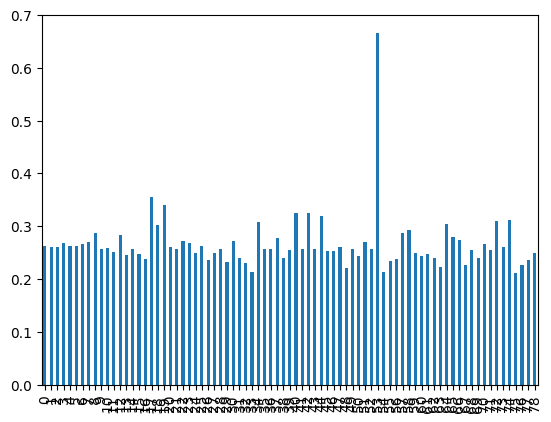

In [ ]:
import pandas as pd
import numpy as np
import cloudpickle
import sklearn

# df=pd.read_csv("../../assets/assignment/df_train.csv.gz")
# holdout_data=df.query("`event.id`!='583f013a-1e54-4906-87f7-2b625206f5f9' and `clean_categories.name`=='5k'")
# holdout_data = df
holdout_data = pd.concat([X_test, y_test], axis=1)#.sample(1000)

def score(left: pd.DataFrame, right: pd.DataFrame):
    '''
    Calculates the difference between the left and the right when considering rank of items. 
    This scoring function requires that the two DataFrames have identical indicies, and that
    they each contain only one column of values and no missing values. Props to Blake Atkinson
    for providing MWE indicating issues with autograder version #1.
    '''
    assert(type(left)==pd.DataFrame)
    assert(type(right)==pd.DataFrame)
    assert(len(left)==len(right))
    assert(not np.any(np.isnan(left)))
    assert(not np.any(np.isnan(right)))
    assert(left.index.equals(right.index))
    # convert to ndarrays
    left=left.squeeze()
    right=right.squeeze()

    # try:
    a = np.sum(np.abs(left-right))/(len(left)*(len(left)-1))
    # except:
    #     a = np.sum(np.abs(left-right))

    return a

def evaluate(data, pipeline_file='pipeline.cloudpickle'):
    fitted_pipe = cloudpickle.load(open(pipeline_file,'rb'))
    
    X=list(set(data.columns)-{'overall_ranking'})
    y=['overall_ranking']
    
    data=data.dropna(subset=['overall_ranking'])
    
    if len(data)==0:
        return np.nan

    # Predict on unseen data
    predictions=pd.DataFrame(fitted_pipe.predict(data[X]),data.index)
    observed=data[y]
    
    # Generate rankings within this bracket
    observed=pd.DataFrame(data[y].rank(),data.index)
    
    # Return the ratio of the student score
    return pd.Series({"score":score(observed,predictions)})

# Student solution
pipeline_file='pipeline.cloudpickle'

# Run prediction on each group
results=holdout_data.groupby(["event.id","clean_categories.name"]).apply(evaluate, pipeline_file)

# Display the results, uncomment this for your own display
results.reset_index()['score'].plot.bar()

# This is the student final grade
print(np.average(results))


In [ ]:
results.reset_index(drop=False).sort_values(by='score', ascending=False)


,event.id,clean_categories.name,score
53,5c019c1b-b370-4732-aa47-1db25206f5f9,fire fighter,0.666667
42,5b6b34d6-40b8-483c-826e-68525206f5f9,5 mile walk,0.323569
39,5b6b34d6-40b8-483c-826e-68525206f5f9,10 mile run,0.320558
19,59dd4424-fe1c-485c-b6cd-1b485206f5f9,2 mile walk,0.320430
44,5b6b34d6-40b8-483c-826e-68525206f5f9,5k walk,0.311824
...,...,...,...
33,5ad8ae00-e10c-4a35-a5c6-5cb35206f5f9,5k run,0.210070
71,5c892c06-6cf0-468b-872d-68695206f5f9,5k,0.209737
76,5e83a579-e5c4-45a1-82bd-792ec0a80a41,10k,0.207565
58,5c6b5dbd-ad4c-4558-aecf-5dbe5206f5f9,5k,0.201052
